# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [6]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [60]:
#x_train.shape
#x_test.shape

In [7]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="DL1")
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="DL2")
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="EL")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = tf.matmul(x, self.layer_3.w) + self.layer_3.b

    return tf.nn.softmax(x)

In [8]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
  y_pred_l = tf.argmax(y_pred, axis=1)
  y_true = tf.cast(y_true, tf.float32)
  y_pred_l = tf.cast(y_pred_l, tf.float32)
  correct_predictions = tf.equal(y_pred_l, y_true)
  accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
  return accuracy

In [27]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y, learning_rate =0.002):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    #optimised_parameters = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    #gradients = g.gradient(loss, optimised_parameters)
    gradients = g.gradient(loss, neural_net.trainable_variables)

    # Модифікуємо параметри
    #optimizer.apply_gradients(zip(gradients, trainable_variables))
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

In [28]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        current_loss = cross_entropy(pred, batch_y)
        accurac = accuracy(pred, batch_y)
        accuracy_history.append(accurac)
        loss_history.append(current_loss)
        #print(f"Step {step:4}, Loss: {current_loss:7.2f}, Accuracy: {accurac:.2%}")
print(f"Loss: {current_loss:7.2f}, Accuracy: {accurac:.2%}")


Step  100, Loss:  191.52, Accuracy: 79.30%
Step  200, Loss:  120.47, Accuracy: 85.55%
Step  300, Loss:  122.97, Accuracy: 85.94%
Step  400, Loss:  123.97, Accuracy: 85.94%
Step  500, Loss:   85.75, Accuracy: 91.02%
Step  600, Loss:   73.91, Accuracy: 91.41%
Step  700, Loss:   96.06, Accuracy: 90.62%
Step  800, Loss:   91.04, Accuracy: 91.02%
Step  900, Loss:   89.98, Accuracy: 89.84%
Step 1000, Loss:   79.46, Accuracy: 87.89%
Step 1100, Loss:   65.50, Accuracy: 91.80%
Step 1200, Loss:   66.79, Accuracy: 91.80%
Step 1300, Loss:   72.06, Accuracy: 92.58%
Step 1400, Loss:   71.24, Accuracy: 94.14%
Step 1500, Loss:   50.54, Accuracy: 93.75%
Step 1600, Loss:   62.99, Accuracy: 92.58%
Step 1700, Loss:   41.79, Accuracy: 94.14%
Step 1800, Loss:   56.88, Accuracy: 93.36%
Step 1900, Loss:   51.76, Accuracy: 94.92%
Step 2000, Loss:   48.17, Accuracy: 93.36%
Step 2100, Loss:   39.81, Accuracy: 95.70%
Step 2200, Loss:   30.34, Accuracy: 97.27%
Step 2300, Loss:   34.52, Accuracy: 96.09%
Step 2400, 

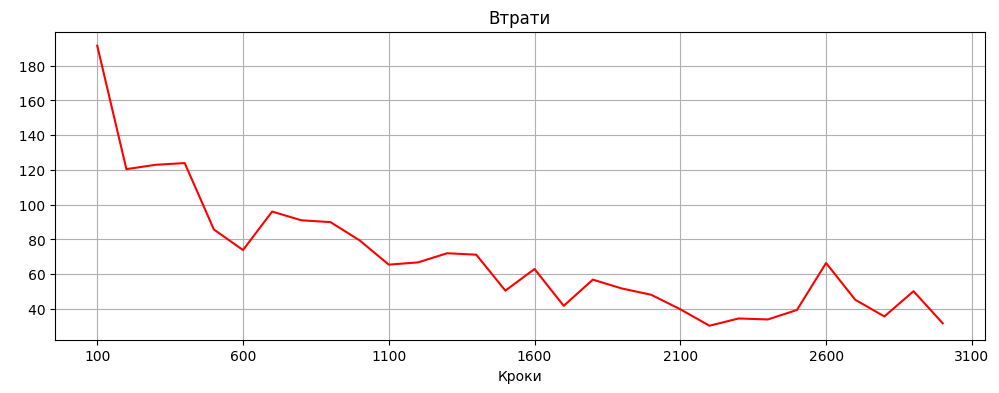

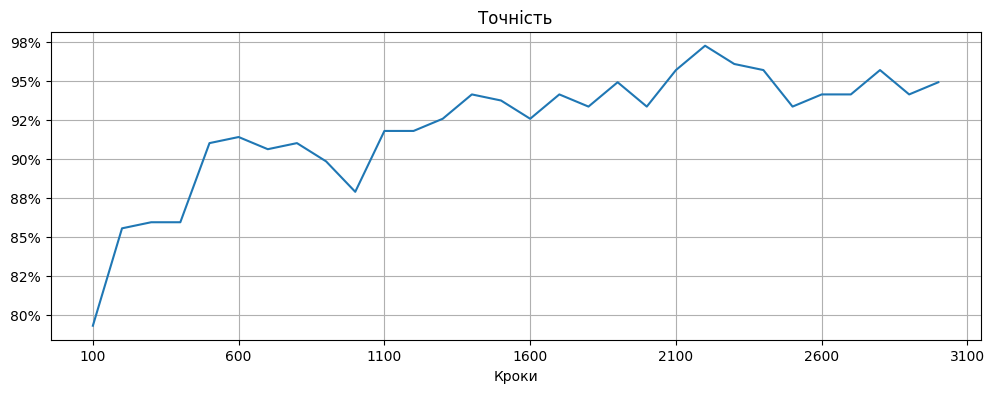

In [29]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат

fig = plt.figure(figsize=(12,4))
plt.plot(loss_history, "r")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):5}'))
plt.xlabel("Кроки")
plt.title("Втрати")
plt.grid()
plt.show()

# Виведіть графік точності
fig = plt.figure(figsize=(12,4))
plt.plot(accuracy_history)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.title("Точність")
plt.xlabel("Кроки")
plt.grid()
plt.show()


In [30]:
# Обчисліть точність навченої нейромережі
accuracy_mean = np.mean(accuracy_history)
print(f"{accuracy_mean=:%}")
# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test).numpy()
print(f"{test_accuracy=:%}")

accuracy_mean=92.070311%
test_accuracy=92.019999%


In [31]:
# Протестуйте навчену нейромережу на 10 зображеннях.

test_selection = 10
test_pred_select = neural_net(x_test[:test_selection])
test_acc_select = accuracy(test_pred_select, y_test[:test_selection]).numpy()
print(f"{test_selection=}, {test_acc_select=:.2%}")


test_selection=10, test_acc_select=90.00%


In [78]:
#З тестової вибірки візьміть 5 випадкових зображень і передайте їх у нейронну мережу.

rand_img = np.random.randint(0, x_test.shape[0], size=5)
pred = neural_net(x_test[rand_img])
acc = accuracy(pred, y_test[rand_img]).numpy()

print(f"selected imnage: {rand_img}")
print("test_values:", y_test[rand_img])

pred_values = np.argmax(pred, axis=1)
print("pred_values:", pred_values)
print(f"accuraccy : {acc:.2%}")

selected imnage: [6546 8731  222 9318 7713]
test_values: [0 0 2 2 8]
pred_values: [0 0 8 2 8]
accuraccy : 80.00%


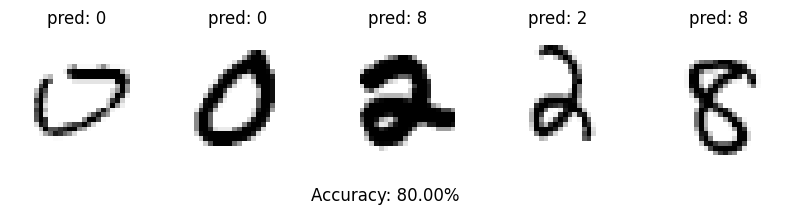

In [79]:
# Виведіть зображення та випишіть поруч відповідь нейромережі.

plt.figure(figsize=(10, 5))
img_size = int(x_test.shape[1]**(1/2))
for i, idx in enumerate(rand_img, start=1):
    plt.subplot(1, 5, i)
    correct = y_test[idx] == pred_values[i-1]
    plt.imshow(x_test[idx].reshape(img_size, img_size), cmap='gray_r')
    plt.title(f'pred: {pred_values[i-1]}')
    plt.axis('off')

plt.suptitle(f"Accuracy: {acc:.2%}")
plt.subplots_adjust(top=2.2)
plt.show()

In [59]:
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
from sklearn.metrics import classification_report
test_pred_values = np.argmax(test_pred, axis=1)
print(classification_report(y_test, test_pred_values))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.99      0.98      0.98      1135
           2       0.90      0.90      0.90      1032
           3       0.92      0.87      0.90      1010
           4       0.91      0.94      0.93       982
           5       0.87      0.90      0.89       892
           6       0.95      0.93      0.94       958
           7       0.94      0.91      0.92      1028
           8       0.84      0.92      0.88       974
           9       0.92      0.88      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



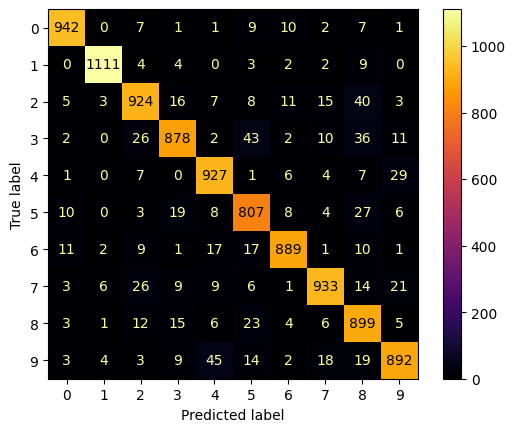

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values, cmap='inferno')
plt.show()

## Висновки  
На тестових даних модель показує точність (accuracy) 92% .  
Найбільше модель поміляеться на "8" (precision 0.84), а найменше правильно визначає "3" (recall 0.87).  
Найкраще з усіх модель визначає цифру "1".
